# Percentage Adjustment Evaluation

In this section, we want to find out whether the combination of emotional features of two languages combined tested on one of the languages used in training influences the results by gradually incorporating a percentage of samples from the testing data into the training data and then testing on the remaining part of the testing data. We try to replicate the results by Lattif et al. although the exact procedure is not specified in detail in the paper. 

First, we import the result data from our percentage adjustment analysis (see percentage_adjustments.ipynb).
Second, we plot the performances of the development of model-accuracy across the increasing test-language percentages using XGBoost (best performing model) with Balanced Accuracy (same metric used in the main paper).

If the integration of test-language data into the training data increases the scores above baseline that would indicate that language-specific features of the testing languages could be less important than emotion-specific features in the overall evaluation process of the models. That could indicate that models trained on multiple languages might be better in detecting emotions than models trained on only one language.

**important note:**
When talking about incorporating test data into the training data we mean a part of the dataset from the testing language. No model will be tested on the same data it was trained on since this would violate any cross-validation guidelines and lead to entirely uninterpretable and overfitted results.

In [198]:
# dependecies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
# Testing with Urdu
train_english = pd.read_csv(r'train_english_test_urdu_percentage.csv')
train_german = pd.read_csv(r'train_german_test_urdu_percentage.csv')
train_italian = pd.read_csv(r'train_italian_test_urdu_percentage.csv')

# Training with Urdu
test_english = pd.read_csv(r'train_urdu_test_english_percentage.csv')
test_german = pd.read_csv(r'train_urdu_test_german_percentage.csv')
test_italian = pd.read_csv(r'train_urdu_test_italian_percentage.csv')

# baselines
baseline_english = pd.read_csv(r'..\Baseline\english_results.csv') 
baseline_german = pd.read_csv(r'..\Baseline\german_results.csv')
baseline_italian = pd.read_csv(r'..\Baseline\italian_results.csv')
baseline_urdu = pd.read_csv(r'..\Baseline\urdu_results.csv')

In [200]:
# Melt the DataFrame to long format for easier plotting
train_english = train_english.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
train_german = train_german.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
train_italian = train_italian.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")

test_english = test_english.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
test_german = test_german.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
test_italian = test_italian.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")

In [201]:
# Define dataset names
train_urdu_names = ['English', 'German', 'Italian']
test_urdu_names = ['English', 'German', 'Italian']
baseline_names = ['German', 'English', 'Italian', 'Urdu']

# combine dataframes
train_urdu_dfs = [test_english, test_german, test_italian]
test_urdu_dfs = [train_english, train_german, train_italian]
baseline_dfs = [baseline_german, baseline_english, baseline_italian, baseline_urdu]

train_urdu_dfs = pd.concat(
        [df.assign(Dataset=name) for df, name in zip(train_urdu_dfs, train_urdu_names)],
        ignore_index=True
    )
test_urdu_dfs = pd.concat(
        [df.assign(Dataset=name) for df, name in zip(test_urdu_dfs, test_urdu_names)],
        ignore_index=True
    )

baseline_dfs = pd.concat(
        [df.assign(Dataset=name) for df, name in zip(baseline_dfs, baseline_names)],
        ignore_index=True
    )

In [202]:
def plot_percentage(model, percentage_dfs, datasets, metric, title):

    scores = [percentage_dfs[(percentage_dfs['Dataset'] == ds) & 
                             (percentage_dfs['Metric'] == metric) & 
                             (percentage_dfs['Model'] == model)]['Score'].values * 100 for ds in datasets]

    scores_df = pd.DataFrame(scores).T
    scores_df.columns = datasets
    scores_df = scores_df.set_index((scores_df.index + 1) * 10)

    #baseline_scores = [baseline_dfs[baseline_dfs['Dataset'] == ds]['Score'].values[0] * 100 for ds in baseline_names]

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    #[plt.axhline(score, linestyle = '--') for score in baseline_scores]
    sns.lineplot(data=scores_df)
    plt.title(f"{title} using {model}")
    plt.xlabel("Percentage of Test Data", fontsize = 12)
    plt.ylabel(f"{metric} (%)", fontsize = 12)
    plt.tight_layout()
    plt.show()

In [203]:
# get baseline
# df_baseline_accuracy = baseline_dfs[(baseline_dfs["Metric"] == "balanced_accuracy") & (baseline_dfs["Model"] == "XGBoost")]

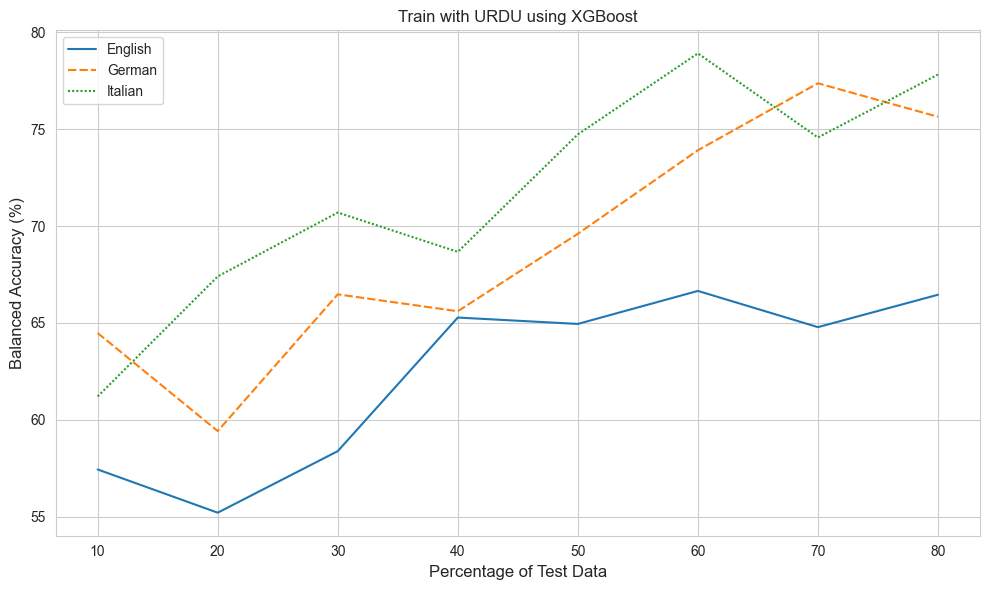

In [204]:
plot_percentage(model="XGBoost", percentage_dfs=train_urdu_dfs, datasets=train_urdu_names, metric="Balanced Accuracy", title=f"Train with URDU")

For the model trained on Urdu and parts of a "western" language, accuracies rise above baseline for every model from a percentage of latest 50%. Consistent with our other analyses, testing on the Italian language produces the best results, especially when comparing to its relatively low baseline accuracy. Hence, we conclude that combining multiple languages during training and testing on one of the languages might increase performance of emotion-detectors.

The less straightly rising lines compared to the main study are caused by our random shuffling approach. With every other seed a different pattern occurs but the overall structure remains with a tendency to more accuracy for higher percentages of incorporated test language data and values above baseline for all instances at some point above 50% of incorporated test data.

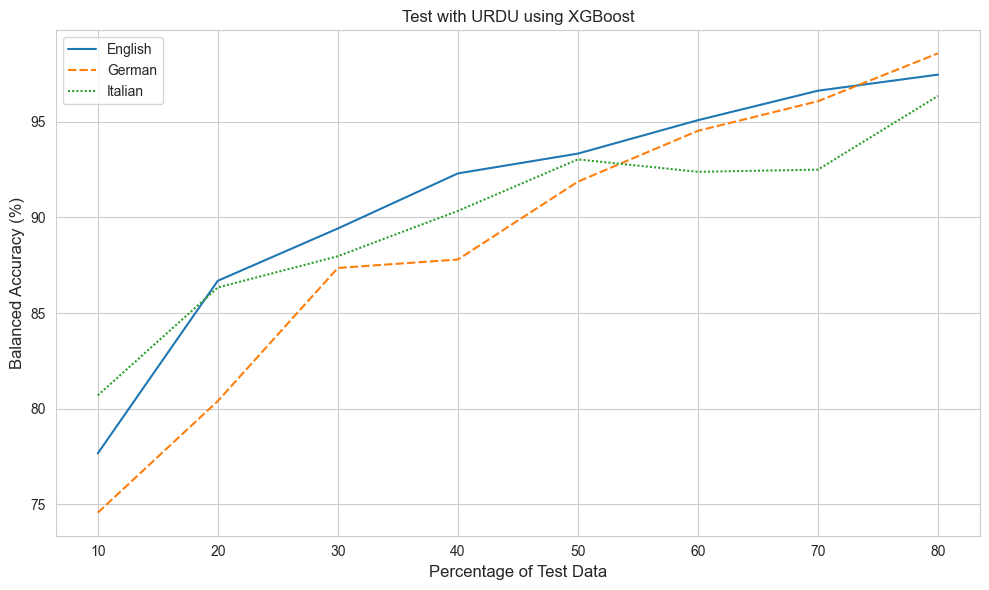

In [205]:
plot_percentage(model="XGBoost", percentage_dfs=test_urdu_dfs, datasets=test_urdu_names, metric="Balanced Accuracy", title="Test with URDU")

For the model trained on a "western" language and parts of a Urdu, accuracies rise above baseline for every model from a percentage of latest 30% onwards with a continuous increase of accuracy up to a point of above 95%. Hence, we conclude that combining multiple languages during training and testing on one of the languages might increase performance of emotion-detectors. 

However, the accuracies for the higher percentages are too high to be taken for granted, it is likely that overfitting plays a part here so the tendency is interpretable here while the absolute results are definitely not.

# Conclusion
We find that for all settings the baseline accuracy can be superceded by incorporating a percentage of data from the testing dataset into the training dataset of another language from a different cultural background. Hence, we conclude that models may benefit from multilingual training if the language it is supposed to be tested on is part of the training data. However, overfitting likely plays a role in here causing that our results have to be interpreted cautiously.